In [149]:
import pandas as pd
import opendatasets as od

In [150]:
# od.download("https://www.kaggle.com/competitions/spaceship-titanic")

In [151]:
raw=pd.read_csv('spaceship-titanic/train.csv')
raw=raw[~raw['Cabin'].isnull()]


In [152]:
ytrain=raw['Transported']

Xtrain=raw.drop(columns=['Transported','Name'])
Xtrain=Xtrain.assign(
    RoomService=Xtrain.RoomService.fillna(0).replace('nan',0).astype(float),
    CryoSleep=Xtrain.CryoSleep.fillna(False),
    VIP=Xtrain.VIP.fillna(False).replace('nan',0),
    FoodCourt=Xtrain.FoodCourt.fillna(0).replace('nan',0).astype(float),
    ShoppingMall=Xtrain.ShoppingMall.fillna(0).replace('nan',0).astype(float),
    Spa=Xtrain.Spa.fillna(0).replace('nan',0).astype(float),
    VRDeck=Xtrain.VRDeck.fillna(0).replace('nan',0),
    Cabin=Xtrain.Cabin.str.split('/',expand=True)[2]=='S' ,
    Age=Xtrain.Age.fillna(Xtrain.Age.median())
)


In [153]:
# Port=Xtrain.Cabin.str.split('/',expand=True)[2]=="P"
# new_cab=new_cab[2]
# S_Cabin= Xtrain.loc[].split()== "S"
# Xtrain=Xtrain[~Xtrain['Cabin'].isnull()]

In [154]:
print(Xtrain.HomePlanet.unique(),"\n",
      Xtrain.HomePlanet.value_counts(dropna=False))

['Europa' 'Earth' 'Mars' nan] 
 Earth     4507
Europa    2070
Mars      1722
NaN        195
Name: HomePlanet, dtype: int64


In [155]:
print(Xtrain.Destination.unique(),"\n", Xtrain.Destination.value_counts(dropna=False))

['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan] 
 TRAPPIST-1e      5788
55 Cancri e      1750
PSO J318.5-22     778
NaN               178
Name: Destination, dtype: int64


In [156]:
Xtrain=pd.get_dummies(Xtrain,columns=['Destination','HomePlanet'])

In [157]:
# encoding boolean labels
from sklearn import preprocessing

label_encoder=preprocessing.LabelEncoder()
ytrain=label_encoder.fit_transform(ytrain).astype(str)
Xtrain.CryoSleep=label_encoder.fit_transform(Xtrain.CryoSleep).astype(str)
Xtrain.Cabin=label_encoder.fit_transform(Xtrain.Cabin).astype(str)
Xtrain.VIP=label_encoder.fit_transform(Xtrain.VIP).astype(str)

# Xtrain.drop(columns=['PassengerId'],inplace=True)

In [158]:
Xtrain.dtypes

PassengerId                   object
CryoSleep                     object
Cabin                         object
Age                          float64
VIP                           object
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Destination_55 Cancri e        uint8
Destination_PSO J318.5-22      uint8
Destination_TRAPPIST-1e        uint8
HomePlanet_Earth               uint8
HomePlanet_Europa              uint8
HomePlanet_Mars                uint8
dtype: object

In [159]:
(Xtrain
 .assign(Transported=ytrain==True)
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu',vmax=1,vmin=-1)
 .set_sticky(axis='index')
)

C:\Users\Tyreek ALEXANDER\AppData\Local\Temp\ipykernel_3484\1571317232.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  .assign(Transported=ytrain==True)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Transported
Age,1.000000,0.123040,0.199336,0.099145,0.191256,0.176268,0.020363,-0.035866,-0.001191,-0.223488,0.237756,0.025343,nan
RoomService,0.123040,1.000000,0.180158,0.428001,0.239585,0.179149,-0.071769,-0.053042,0.091640,-0.025553,-0.199924,0.248601,nan
FoodCourt,0.199336,0.180158,1.000000,0.186424,0.468248,0.494490,0.057574,-0.064347,-0.011509,-0.056836,0.266965,-0.213856,nan
ShoppingMall,0.099145,0.428001,0.186424,1.000000,0.255240,0.187024,-0.080166,-0.028348,0.084507,0.025301,-0.189419,0.175028,nan
Spa,0.191256,0.239585,0.468248,0.255240,1.000000,0.435542,0.021424,-0.072394,0.023727,-0.058194,0.169800,-0.107780,nan
VRDeck,0.176268,0.179149,0.494490,0.187024,0.435542,1.000000,0.039015,-0.054565,-0.004567,-0.008503,0.202450,-0.203554,nan
Destination_55 Cancri e,0.020363,-0.071769,0.057574,-0.080166,0.021424,0.039015,1.000000,-0.161754,-0.745007,-0.147314,0.289871,-0.118582,nan
Destination_PSO J318.5-22,-0.035866,-0.053042,-0.064347,-0.028348,-0.072394,-0.054565,-0.161754,1.000000,-0.464402,0.231596,-0.163138,-0.111393,nan
Destination_TRAPPIST-1e,-0.001191,0.091640,-0.011509,0.084507,0.023727,-0.004567,-0.745007,-0.464402,1.000000,-0.016794,-0.146873,0.169439,nan
HomePlanet_Earth,-0.223488,-0.025553,-0.056836,0.025301,-0.058194,-0.008503,-0.147314,0.231596,-0.016794,1.000000,-0.603536,-0.536141,nan


It seems that the persons who have billed luxury amenities have a negative relationship with being transported. In simple words, the people who have bills are less likely to be transported.

In [160]:
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import tree

stump_dt=tree.DecisionTreeClassifier(max_depth=1)
stump_dt.fit(Xtrain,ytrain)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'CryoSleep <= 0.5\ngini = 0.5\nsamples = 8494\nvalue = [4216, 4278]\nclass = 1'),
 Text(0.25, 0.25, 'gini = 0.446\nsamples = 5541\nvalue = [3679, 1862]\nclass = 0'),
 Text(0.75, 0.25, 'gini = 0.298\nsamples = 2953\nvalue = [537, 2416]\nclass = 1')]

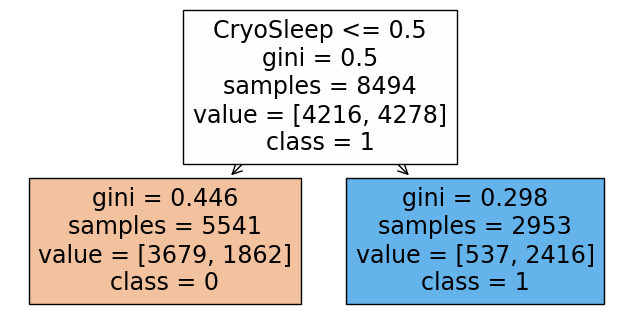

In [161]:
fig,ax=plt.subplots(figsize=(8,4))
features= list(c for c in Xtrain.columns)
tree.plot_tree(stump_dt,
               feature_names=features,
               filled=True,
               class_names=stump_dt.classes_,
               ax=ax)